In [1]:
import getData
import logging
import os
import sys
import tempfile

import torch
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import monai
from monai.data import create_test_image_2d, list_data_collate, decollate_batch
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    AddChanneld,
    AsDiscrete,
    Compose,
    LoadImaged,
    RandCropByPosNegLabeld,
    RandRotate90d,
    RandFlipd,
    Rand2DElasticd,
    ScaleIntensityd,
    EnsureTyped,
    EnsureType,
    RandGaussianNoised,
    KeepLargestConnectedComponent,
    FillHoles
)
from monai.visualize import plot_2d_or_3d_image
from monai.networks.nets import UNet

In [6]:
# Get Data
_, _, val_images, val_segs, test_images, test_segs = getData.getImageSegTrainValTest("ALL")

test_files = [{"img": img, "seg": seg}
                for img, seg in zip(test_images, test_segs)]

test_transforms = Compose(
    [
        LoadImaged(keys=["img", "seg"]),
        AddChanneld(keys=["img", "seg"]),
        ScaleIntensityd(keys=["img", "seg"]),
        EnsureTyped(keys=["img", "seg"]),
    ]
)
#Setup DataLoader
test_ds = monai.data.Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1,
                        num_workers=4, collate_fn=list_data_collate)
dice_metric = DiceMetric(include_background=False,
                          reduction="mean", get_not_nans=False)



post_trans = Compose([EnsureType(), Activations(
        sigmoid=True), AsDiscrete(threshold=0.5)]) #,FillHoles(connectivity = 2, applied_labels = [1]),KeepLargestConnectedComponent(applied_labels = [1], independent = True, connectivity = 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

model.load_state_dict(torch.load(
    "ALL_4l_rotFlip_1000epochs.pth"))

#print(model)

<All keys matched successfully>

In [7]:
#Evaluation loop
FP = 0
FN = 0
TP = 0
TN = 0
dice_metric.reset()
model.eval()

with torch.no_grad():
    i = 0
    for test_data in test_loader:
        test_images, test_labels = test_data["img"].to(
            device), test_data["seg"].to(device)
        test_outputs = model(test_images)
        test_outputs = [post_trans(i) for i in decollate_batch(test_outputs)]
        test_labels = decollate_batch(test_labels)
        # compute metric for current iteration
        dice_metric(y_pred=test_outputs, y=test_labels)

        test_outputs = test_outputs[0].cpu().detach().numpy()
        test_labels = test_labels[0].cpu().detach().numpy()
        FP += len(np.where(test_outputs - test_labels == -1)[0])
        FN += len(np.where(test_outputs - test_labels == 1)[0])
        TP += len(np.where(test_outputs + test_labels == 2)[0])
        TN += len(np.where(test_outputs + test_labels == 0)[0])
        
    # aggregate the final mean dice result
    print("Dice score:", dice_metric.aggregate().item())

    # reset the status
    dice_metric.reset()

Dice score: 0.9157990217208862


In [8]:
total = FP + FN + TP + TN
print(FP/total)
print(FN/total)
print(TP/total)
print(TN/total)
accuracy = (TP + TN)/(FP+FN+TP+TN) 
precision = TP/(TP+FP)
recall = TP/(TP+FN)
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)

0.0029694718447397864
0.005044662447918676
0.04823305518450291
0.9437528105228387
Accuracy:  0.9919858657073415
Precision:  0.9420053654179242
Recall:  0.9053138409058124


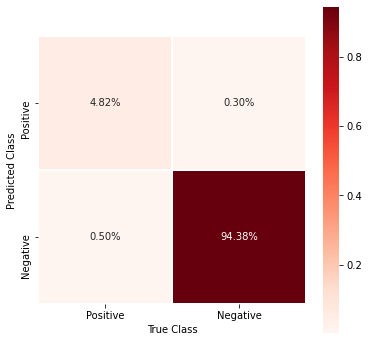

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
cmat = [[TP, FP], [FN, TN]]

plt.figure(figsize = (6,6))
x_labels = ["Positive", "Negative"]
y_labels = ["Positive", "Negative"]
sns.heatmap(cmat/np.sum(cmat), cmap="Reds", annot=True, fmt = '.2%', square=1,   linewidth=2.,
  xticklabels = x_labels, yticklabels = y_labels)
plt.xlabel("True Class")
plt.ylabel("Predicted Class")
plt.show()

In [13]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


def main(tempdir):
    monai.config.print_config()
    logging.basicConfig(stream=sys.stdout, level=logging.INFO)

    _, _, val_images, val_segs, test_images, test_segs = getData.getImageSegTrainValTest("ALL")

    val_files = [{"img": img, "seg": seg} for img, seg in zip(val_images, val_segs)]

    # define transforms for image and segmentation
    val_transforms = Compose(
        [
            LoadImaged(keys=["img", "seg"]),
            AddChanneld(keys=["img", "seg"]),
            ScaleIntensityd(keys=["img", "seg"]),
            EnsureTyped(keys=["img", "seg"]),
        ]
    )
    # setup dataset and dataloaders
    val_ds = monai.data.Dataset(data=val_files, transform=val_transforms)
    val_loader = DataLoader(val_ds, batch_size=1,
                            num_workers=4, collate_fn=list_data_collate)
    dice_metric = DiceMetric(include_background=False,
                             reduction="mean", get_not_nans=False)

    post_trans = Compose([EnsureType(), Activations(
        sigmoid=True), AsDiscrete(threshold=0.5)])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNet(
        spatial_dims=2,
        in_channels=1,
        out_channels=1,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
    ).to(device)

    model.load_state_dict(torch.load(
        "ALL_4l_rotFlip_1000epochs.pth"))

    #calculate dice
    model.eval()
    with torch.no_grad():
        for val_data in val_loader:
            val_images, val_labels = val_data["img"].to(
                device), val_data["seg"].to(device)
            val_output = model(val_images)
            val_outputs = [post_trans(i) for i in decollate_batch(val_output)]
            val_labels = decollate_batch(val_labels)
            # compute metric for current iteration
            dice_metric(y_pred=val_outputs, y=val_labels)
        # aggregate the final mean dice result
        print("evaluation metric:", dice_metric.aggregate().item())
        # reset the status
        dice_metric.reset()


if __name__ == "__main__":
    with tempfile.TemporaryDirectory() as tempdir:
        main(tempdir)


MONAI version: 0.8.0
Numpy version: 1.19.3
Pytorch version: 1.8.2+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 714d00dffe6653e21260160666c4c201ab66511b

Optional dependencies:
Pytorch Ignite version: 0.4.6
Nibabel version: 3.2.2
scikit-image version: 0.19.1
Pillow version: 9.0.1
Tensorboard version: 2.5.0
gdown version: 4.2.1
TorchVision version: 0.9.2+cu111
tqdm version: 4.58.0
lmdb version: 1.3.0
psutil version: 5.8.0
pandas version: 1.1.4
einops version: 0.4.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies

file written: c:\Users\EmilR\Documents\Datalogi\bachelor\temp\output\0\0_seg.png.
file written: c:\Users\EmilR\Documents\Datalogi\bachelor\temp\output\1\1_seg.png.
file written: c:\Users\EmilR\Documents\Datalogi\bachelor\temp\output\2